# Evaluate region-specific classification thresholds

### Regions of interest: ARISE sites

- VAG in Namibia
- VAG in Zambia -> no overlap between prediction for exemplary VAG and sampled points from KAZA Bengo Crop 2020 Random 20000 dataset
- VAG in Zimbabwe

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_theme()

## Actual sampled train and test points within region of interest

Dataset: KAZABengoCrop2020Random20000

## Test set predictions from random forest within region of interest

Evaluate different classification thresholds for random forest based on the sampled test points within the region of interest.

Data used for training: KAZABengoCrop2020Random20000

# Test set predictions from OpenMapFlow model within region of interest

Evaluate different classification thresholds for OpenMapFlow model based on predicted points that match train and test points from sampled dataset - within the region of interest.

Data used for training: GeowikiLandcover2017 and KAZABengoCrop2020Random2000

Note: There is a certain chance that one of the test samples from KAZABengoCrop2020Random20000 was actually included in the training set created within OpenMapFlow based on the KAZABengoCrop2020Random2000 dataset.

## Compare test set predictions from random forest and OpenMapFlow model for different regions of interest

In [4]:
def compare_accuracies(region_of_interest, directory):
    
    ### actual labels
    
    # load actual labels
    file = 'actual_labels.csv'
    path = os.path.join(directory, file)
    actual_labels = pd.read_csv(path)
    
    # prepare coordinates
    actual_labels['lon'] = actual_labels.apply(lambda x: eval(x['.geo'])['coordinates'][0], axis=1)
    actual_labels['lat'] = actual_labels.apply(lambda x: eval(x['.geo'])['coordinates'][1], axis=1)
    actual_labels = actual_labels.drop('.geo', axis=1)    
    
    
    
    ### random forest class probabilities
    
    # load random forest predictions
    file = 'random_forest_class_probabilities.csv'
    path = os.path.join(directory, file)
    random_forest_class_probabilities = pd.read_csv(path)
    
    # prepare predictions
    random_forest_class_probabilities['system:index'] = random_forest_class_probabilities['system:index'].apply(lambda x: x.split('_')[0])
    random_forest_class_probabilities = random_forest_class_probabilities[['system:index', 'classification']]
    random_forest_class_probabilities = pd.merge(actual_labels, random_forest_class_probabilities, how='inner', on='system:index')
    random_forest_class_probabilities = random_forest_class_probabilities.drop(['system:index', 'lon', 'lat'], axis=1)
    random_forest_class_probabilities = random_forest_class_probabilities.rename(columns={'classification': 'crop_probability'})
    
    # calculate accuracies at different thresholds
    thresholds = np.arange(0.1,1.1,0.1)
    actual_test_labels = list(random_forest_class_probabilities['crop'])
    accuracies_rf = []
    for threshold in thresholds:
        predictions = [1 if i >= threshold else 0 for i in list(random_forest_class_probabilities['crop_probability'])]
        accuracy = round(accuracy_score(actual_test_labels, predictions), 2)
        accuracies_rf.append(accuracy)
    
    
    
    ### OpenMapFlow predictions
    
    # load OpenMapFlow predictions
    openmapflow_predictions = pd.DataFrame()
    for threshold in thresholds:
        if threshold == 1.0:
            threshold = 1
        file = 'openmapflow_predictions_threshold_' + str(round(threshold, 2)).replace('.', '_') + '.csv'
        path = os.path.join(directory, file)
        openmapflow_predictions_temp = pd.read_csv(path)
        openmapflow_predictions_temp['threshold'] = threshold
        openmapflow_predictions = pd.concat([openmapflow_predictions, openmapflow_predictions_temp], ignore_index=True)
    
    # prepare coordinates
    openmapflow_predictions['lon'] = openmapflow_predictions.apply(lambda x: eval(x['.geo'].replace('false', '0'))['coordinates'][0], axis=1)
    openmapflow_predictions['lat'] = openmapflow_predictions.apply(lambda x: eval(x['.geo'].replace('false', '0'))['coordinates'][1], axis=1)
    openmapflow_predictions = openmapflow_predictions.drop(['system:index', 'count', '.geo'], axis=1)
    
    # transform to GeoDataFrame
    openmapflow_predictions = gpd.GeoDataFrame(openmapflow_predictions, geometry=gpd.points_from_xy(openmapflow_predictions.lon, openmapflow_predictions.lat))
    actual_labels = gpd.GeoDataFrame(actual_labels, geometry=gpd.points_from_xy(actual_labels.lon, actual_labels.lat))
    
    # join with sampled train and test points
    openmapflow_predictions = gpd.sjoin_nearest(openmapflow_predictions, actual_labels, how='inner')
    
    # calculate accuracy at different thresholds
    accuracies_omf = []
    for threshold in thresholds:
        true = list(openmapflow_predictions[openmapflow_predictions['threshold'] == threshold]['crop'])
        pred = list(openmapflow_predictions[openmapflow_predictions['threshold'] == threshold]['prediction'])
        accuracy = round(accuracy_score(true, pred), 2)
        accuracies_omf.append(accuracy)
    
    # plot accuracies for random forest and OpenMapFlow model
    rf_test_samples = random_forest_class_probabilities.shape[0]
    omf_test_samples = int(openmapflow_predictions.shape[0] / len(thresholds))
    plt.plot(thresholds, accuracies_rf, marker='o', label=f'Random forest (test samples: {rf_test_samples})')
    plt.plot(thresholds, accuracies_omf, marker='x', label=f'OpenMapFlow model (test samples: {omf_test_samples})')
    plt.xticks(thresholds)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy at different classification thresholds - {region_of_interest}')
    plt.legend()
    plt.show()

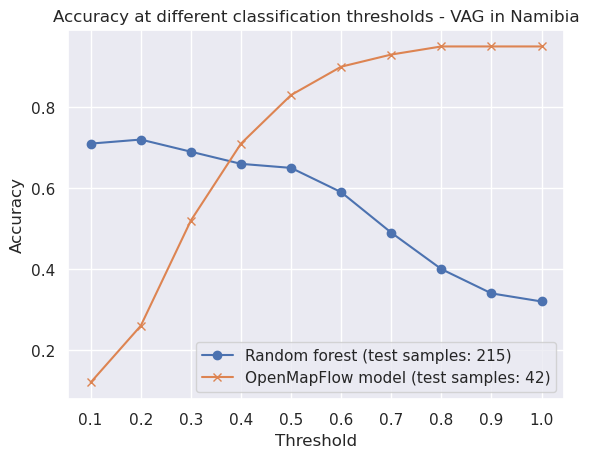

CPU times: user 792 ms, sys: 209 ms, total: 1 s
Wall time: 685 ms


In [5]:
%%time
compare_accuracies('VAG in Namibia', '../processed_data/classification_threshold_evaluation/NAM')

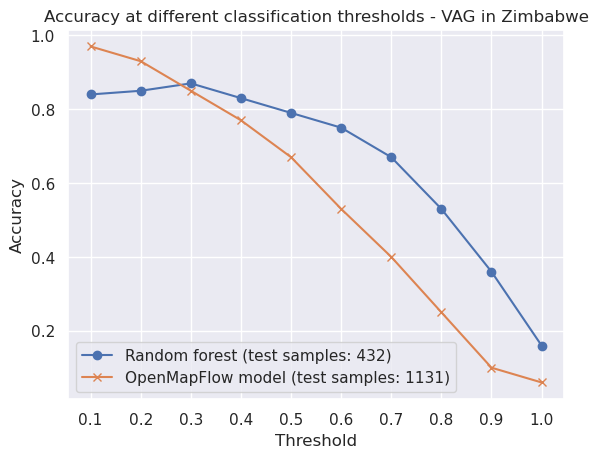

CPU times: user 2.25 s, sys: 148 ms, total: 2.4 s
Wall time: 2.19 s


In [6]:
%%time
compare_accuracies('VAG in Zimbabwe', '../processed_data/classification_threshold_evaluation/ZIM')